# AI3000: Reinforcement Learning : Coding part
## Assignment 2
### Donal Loitam( AI21BTECH11009)

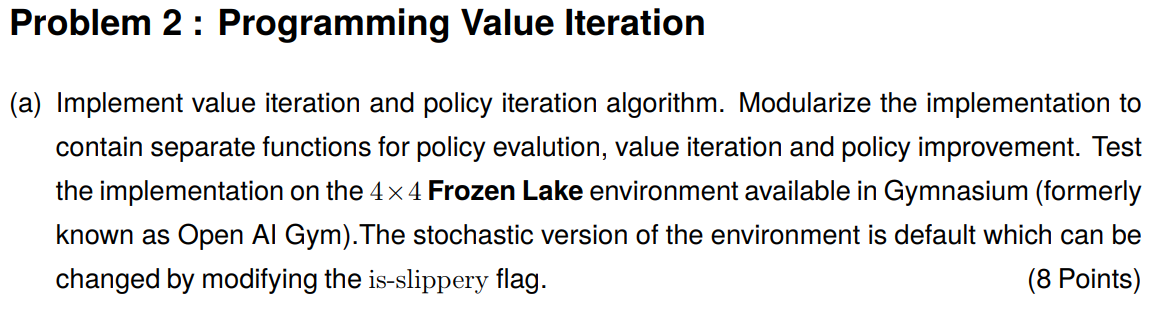

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import imageio

In [2]:
def get_policy(n_states, n_actions, state_prob, P, V, gamma):
    
    for state in range(n_states):
        Q_state_action = np.zeros(n_actions)
        for action in range(n_actions):
            for prob, next_state, reward, done in state_prob[state][action]:
                Q_state_action[action] += prob * (reward + gamma * V[next_state])
                
        P[state] = np.argmax(Q_state_action).astype(int)
        
    return P  


def value_iteration(env, gamma, max_iterations, delta, custom = False):
    
    n_states = env.observation_space.n
    n_actions = env.action_space.n

    state_prob = env.P
    
    V1 = np.zeros(n_states)
    P1 = np.zeros(n_states)
    
    for i in range(max_iterations):
        V_prev = np.copy(V1)
        maxi = 0
        
        for state in range(n_states):
            Q_values_list_curr_state = []
            for action in range(n_actions):
                Q_state_action = 0
                for transition_prob, next_state, reward_prob, _ in state_prob[state][action]:
                    Q_state_action += transition_prob * (reward_prob + gamma * V_prev[next_state])
                    
                Q_values_list_curr_state.append(Q_state_action)
                
            V1[state] = max(Q_values_list_curr_state)
            
            # Keep track of the maximum change among the value functions of states in this iteration
            change = abs(V1[state] - V_prev[state])
            maxi = max(change, maxi)
            
        if(maxi < delta):
            n_iters = i + 1
            print(f"With discount factor = {gamma}, delta = {delta}: Value Iteration converged in {i + 1} iterations. ")
            break
        
    P1 = get_policy(n_states, n_actions, state_prob, P1, V1, gamma)
        
    return V1, P1.astype(int), n_iters
  

In [3]:
def policy_evaluation(env, P, gamma, delta, custom = False):
    n_states = env.observation_space.n
    n_actions = env.action_space.n    
    V = np.zeros(n_states)

    state_prob = env.P
    V_new = np.zeros(n_states)

    # Assuming deterministic policy
    flag = True

    while flag:
        change = 0
        
        for state in range(n_states):
            sum_of_expected_rewards = 0
            action = P[state]             # action suggested by the policy
            
            # Calculate the expected rewards for state 'state' using the current policy P
            for prob, next_state, reward, done in state_prob[state][action]:            # P_ss'a, s', r, done
                sum_of_expected_rewards += prob * (reward + gamma * V[next_state])
                      
            change = max(change, abs(sum_of_expected_rewards - V[state]))  # Update delta
            V_new[state] = sum_of_expected_rewards    # Update state value
        
        V = V_new.copy()  # Update the value function for the next iteration
        
        if change < delta:  # Check for convergence
            flag = False
        
    return V         # Return the converged state-value function
        

    
def policy_improvement(env, V, gamma, custom):
    
    n_states = env.observation_space.n
    n_actions = env.action_space.n    
    new_P = np.zeros(n_states, dtype = int)
    state_prob = env.P
    
    for state in range(n_states):
        Q_values = np.zeros(n_actions)
        for action in range(n_actions):
            for prob, next_state, reward, _ in state_prob[state][action]:
                Q_values[action] += prob * (reward + gamma * V[next_state])
                
        new_P[state] = np.argmax(Q_values)      # Select the action with the highest Q-value 
        
    return new_P
            

    
def policy_iteration(env, max_iterations, gamma, delta, custom = False):
    
    n_states = env.observation_space.n
    n_actions = env.action_space.n 
    
    V = np.zeros(n_states)
    # Initialize the policy with a random policy
    P = np.random.randint(0, n_actions, n_states)
    n_iters = 0
    for i in range(max_iterations):

        V = policy_evaluation(env, P, gamma, delta, custom)
         
        improved_P = policy_improvement(env, V, gamma, custom)   # improve the policy using value iteration 

        if np.array_equal(improved_P, P):
            n_iters = i + 1
            print(f"With discount factor = {gamma}, delta = {delta} : Policy iteration Converged after {i+1} iterations.")
            break

        P = improved_P

    return P, n_iters  
    
        

In [4]:
import imageio

In [5]:
def render_environment_given_a_policy(env, P, policy_name, gif_name, deterministic = True):
    
    n_moves = 0
    state, info = env.reset()
    episode_reward = 0
    done = False
    frames = []
    frames.append(env.render())
    while not done:
        if deterministic:
            action = P[state]
        else:
            action = np.argmax(P[state])

        next_state, reward, terminated, truncated, info = env.step(action)
        frames.append(env.render())
        n_moves += 1
        state = next_state
        episode_reward += reward
        done = terminated or truncated
            
    imageio.mimsave(gif_name, frames, duration=5, loop=0)
    env.close()


## Deterministic Environment

In [6]:
env = gym.make('FrozenLake-v1', render_mode="rgb_array", map_name="4x4", is_slippery=False)

# Define parameters
gamma = 0.9
delta = 1e-6
max_iterations = 1000

print("In a non-stochastic environment :")
P_pi_non_stochastic, n_iters_pi_non_stochastic = policy_iteration(env, max_iterations, gamma, delta)

V_vi_non_stochastic, P_vi_non_stochastic, n_iters_vi_non_stochastic = value_iteration(env, gamma, max_iterations, delta)

print(P_pi_non_stochastic)
print(P_vi_non_stochastic)
print("\n")
render_environment_given_a_policy(env, P_pi_non_stochastic, 'Policy Iteration', 'Policy_iteration_deterministic.gif', True)
render_environment_given_a_policy(env, P_vi_non_stochastic,'Value Iteration', 'Value_iteration_deterministic.gif', True)
env.close()

In a non-stochastic environment :
With discount factor = 0.9, delta = 1e-06 : Policy iteration Converged after 5 iterations.
With discount factor = 0.9, delta = 1e-06: Value Iteration converged in 7 iterations. 
[1 2 1 0 1 0 1 0 2 1 1 0 0 2 2 0]
[1 2 1 0 1 0 1 0 2 1 1 0 0 2 2 0]




c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.P to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.P` for environment variables or `env.get_wrapper_attr('P')` that will search the reminding wrappers.
  logger.warn(


Both gives the same policy : -


![Alt Text](Policy_iteration_deterministic.gif)


## Stochastic Environment

In [7]:
env = gym.make('FrozenLake-v1', render_mode="rgb_array", map_name="4x4", is_slippery=True)
print("In a stochastic environment :")
P_pi_stochastic, n_iters_pi_stochastic = policy_iteration(env, max_iterations, gamma, delta)

V_vi_stochastic, P_vi_stochastic, n_iters_vi_stochastic = value_iteration(env, gamma, max_iterations, delta)

print(P_pi_stochastic)
print(P_vi_stochastic)
print("\n")


render_environment_given_a_policy(env, P_pi_stochastic, 'Policy Iteration', 'Policy_iteration_stochastic.gif', True)
render_environment_given_a_policy(env, P_vi_stochastic,'Value Iteration', 'Value_iteration_stochastic.gif', True)
env.close()

In a stochastic environment :
With discount factor = 0.9, delta = 1e-06 : Policy iteration Converged after 4 iterations.
With discount factor = 0.9, delta = 1e-06: Value Iteration converged in 78 iterations. 
[0 3 0 3 0 0 0 0 3 1 0 0 0 2 1 0]
[0 3 0 3 0 0 0 0 3 1 0 0 0 2 1 0]




Both gives the same policy : -


![Alt Text](Policy_iteration_stochastic.gif)


### Helper function to plot the optimal policy

In [8]:
def plot_policy_beside_env(policy):
    grid = np.zeros((4, 4))
    
    arrows = ['←', '↓', '→', '↑']

    fig, ax = plt.subplots(figsize=(4, 4))

    for i in range(4):
        for j in range(4):
            state = i * 4 + j
            action = policy[state]
            arrow = arrows[int(action)]
            x = j
            y = 3 - i
            ax.annotate(arrow, xy=(x, y), fontsize=18, ha='center', va='center')

    ax.set_xticks(np.arange(0, 4, 1), minor=False)
    ax.set_yticks(np.arange(0, 4, 1), minor=False)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=2)
    ax.axis('off')

    plt.show()

## Optimal Policies in Non Stochastic 

Given the Frozen lake environment, The Optimal Policy according to Policy Iteration can be shown as :-


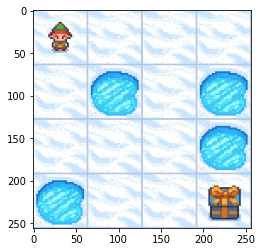

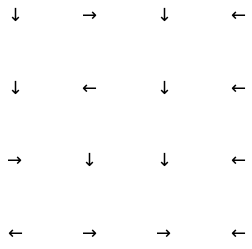

In [9]:
env = gym.make('FrozenLake-v1', render_mode="rgb_array", map_name="4x4", is_slippery=False)
env.reset()
plt.imshow(env.render())
print("Given the Frozen lake environment, The Optimal Policy according to Policy Iteration can be shown as :-")
plot_policy_beside_env(P_pi_non_stochastic)
env.close()

Given the Frozen lake environment, The Optimal Policy according to Value Iteration can be shown as :-


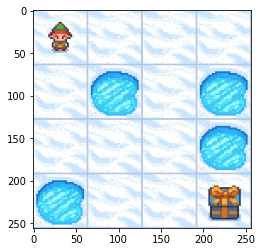

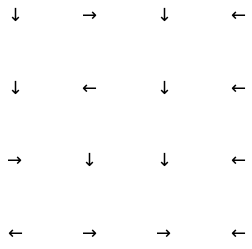

In [10]:
env = gym.make('FrozenLake-v1', render_mode="rgb_array", map_name="4x4", is_slippery=False)
env.reset()
plt.imshow(env.render())
print("Given the Frozen lake environment, The Optimal Policy according to Value Iteration can be shown as :-")
plot_policy_beside_env(P_vi_non_stochastic)

## Optimal Policies in Stochastic Environment

Given the Frozen lake stochastic environment, The Optimal Policy according to Policy Iteration can be shown as :-


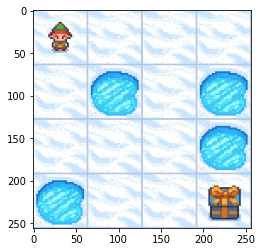

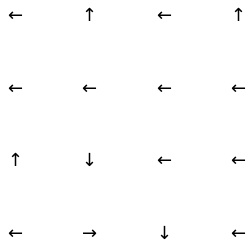

In [11]:
env = gym.make('FrozenLake-v1', render_mode="rgb_array", map_name="4x4", is_slippery=True)
env.reset()
plt.imshow(env.render())
print("Given the Frozen lake stochastic environment, The Optimal Policy according to Policy Iteration can be shown as :-")
plot_policy_beside_env(P_pi_stochastic)
env.close()

Given the Frozen lake stochastic environment, The Optimal Policy according to Policy Iteration can be shown as :-


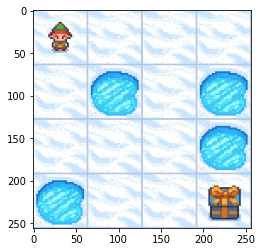

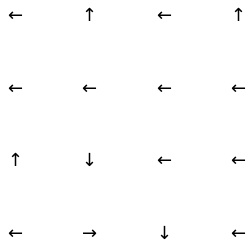

In [12]:
env = gym.make('FrozenLake-v1', render_mode="rgb_array", map_name="4x4", is_slippery=True)
env.reset()
plt.imshow(env.render())
print("Given the Frozen lake stochastic environment, The Optimal Policy according to Policy Iteration can be shown as :-")
plot_policy_beside_env(P_vi_stochastic)
env.close()

## Q2.(b)

![Alt text](image.png)

### Answer :
Having conducted some experiments with value iteration, policy iteration and tweaking with the stochasticity of the Frozen lake environment, here are some findings :- 
- In a Non-Stochastic environment, the number of iterations required for the policy and value iteration are almost the same. With ($\gamma$ = 0.9) and ($\epsilon = 1e^{-6}$)
    - Value iteration took 7 iterations each time to converge (as Value function is initialised to 0 for each state every time)
    - Policy iteration took 5-7 iterations to converge depending upon the initialisation of the policy (Random Initialisation of Policy is used each time resulting in different number of iterations)
- While in a Stochastic environment, the number of iterations required for the policy and value iteration differs a lot. With ($\gamma$ = 0.9) and ($\epsilon = 1e^{-6}$)
    - Value iteration took 78 iterations each time to converge (since Value function is initialised to 0 for each state every time)
    - Policy iteration took 5-7 iterations to converge depending upon the initialisation of the policy (Random Initialisation of Policy is used each time resulting in different number of iterations)
    
- The optimal Policy arrived at by both the algorithms are identical, irrespective of the nature of environment.
- The optimal Policies for Stochastic environment is however, DIFFERENT from that of Non-Stochastic environment.
- Reason why value iteration may take more iterations to converge compared to policy iteration may be because of the following reasons :-
    - Value iteration involves updating the value estimates for all states in each iteration. In a stochastic environment, the estimates can be highly uncertain due to the probabilistic state transitions.
    - Since value iteration computes the maximum expected value for each state in each iteration, it tends to be more sensitive to the noisy estimates of state values.
    - Thus making it harder for the algorithm to converge
    - Policy iteration, on the other hand, improves the policy in the policy evaluation step
    - It doesn't necessarily require all state values to converge before making policy updates.

- The snapshots as found earlier are :- 
    - NON-STOCHASTIC ENVIRONMENT : Both gives the same optimal policy.

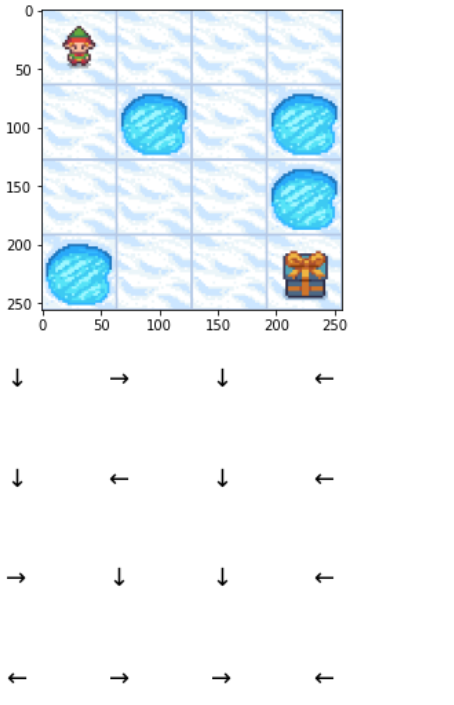

   - STOCHASTIC ENVIRONMENT : Both gives the same optimal policy.

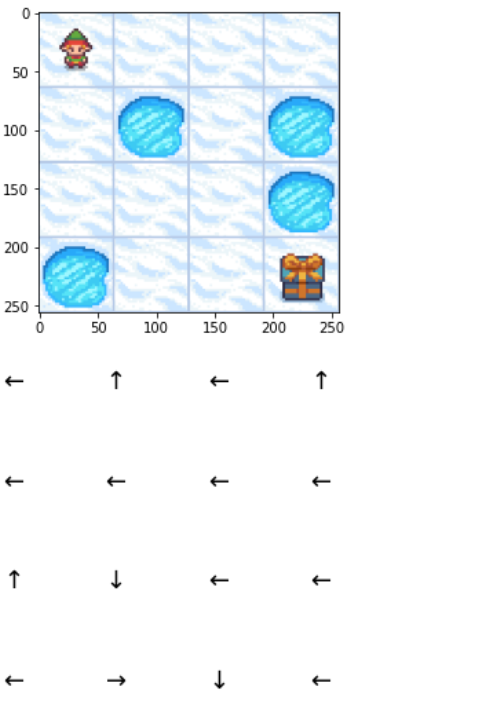

## Q2 (c)
![Alt text](image-3.png)

### Answer : 
- There can be many stochastic optimal policies for given Frozen Lake Environment(as was discussed in class)
- But, the optimal policies which we found using the above 2 DP algorithms gives us DETERMINISTIC POLICY
$$
    \begin{align}
         \pi^{}   &= greedy~(V^{})
    \end{align}
$$
- Since it is using argmax function to get optimal action , the python returns the first occurence of maximum. But actually if we have equal (R + $\gamma$V(s)) value at surrounding states those actions will be equiprobable


## Q2 (d) 
## Implementing a Custom environment
![Alt text](image-4.png)

In [13]:
from gymnasium import spaces
import gymnasium as gym
import random
import tkinter as tk

In [14]:
class CustomGridEnv(gym.Env):
    def __init__(self, discount_factor, noise_factor):
        
        # If we want the user to be able to tweak with the environment, then we can make these as parameters
        self.grid_size = (5,5)
        self.start_state = (3,0)
        self.goal_states = [(2,2),(2,4)]
        self.cliff_states = [(4, i) for i in range(5)]
        self.wall_states = [(1,1), (2,1), (2,3)]
        
        self.coordinate_to_index = {}
        self.index_to_coordinate = {}
        index = 0
        for row in range(self.grid_size[0]):
            for col in range(self.grid_size[1]):
                if (row, col) not in self.wall_states:
                    self.coordinate_to_index[(row, col)] = index
                    self.index_to_coordinate[index] = (row, col)
                    index += 1
        
        self.action_space = spaces.Discrete(4)  # L,R,U,D (left right up down)
        self.observation_space = spaces.Discrete(22)    # 25 - 3 = 22, where 3 are wall states
        
        self.discount_factor = discount_factor
        self.noise_factor = noise_factor
        
        self.terminated = False
        self.truncated = False
        self.state = self.start_state
        self.P = self.transition_prob()

        self.root = tk.Tk()
        self.canvas = tk.Canvas(self.root, width=300, height=300)
        self.canvas.pack()
        
        
    def reset(self):
        self.state = self.start_state
        state_index = self.coordinate_to_index[self.state]
        self.terminated = False
        self.truncated = False
        
        return state_index
        
    
    def step(self, action):
        if self.terminated:
            return self.state, 0, True, False, {}
        if self.truncated:
            return self.state, 0, False, True, {}           
            
        
        next_state = self.get_next_state(self.state, action, self.noise_factor)
        reward = self.calc_reward(self.state)
        self.state = next_state                     # we wont be implementing truncated because its a small environment
        next_state_index = self.coordinate_to_index[next_state]
        
        return next_state_index, reward, self.is_terminal(next_state), False, {} 
        
        
    
    def is_terminal(self, state):
        if state in self.goal_states or state in self.cliff_states:
            return True
                
        return False
        
    def get_next_state(self, state, action, noise):
        if random.uniform(0, 1) < noise:  # randomly choose any action among the other 3 actions
            random_action = random.choice([a for a in range(4) if x != action])
            
        x, y = state
        if action == 0:      # Left
            y_new = max(0, y - 1)                        # column changed
            x_new = x
            if (x_new, y_new) in self.wall_states:
                y_new = y
                
        elif action == 1:    # Right
            y_new = min(self.grid_size[1] - 1, y + 1)      # column changed
            x_new = x
            if (x_new, y_new) in self.wall_states:
                y_new = y                
                
        elif action == 2:     # Up
            x_new = max(0, x - 1)                       # Row changed
            y_new = y
            if (x_new, y_new) in self.wall_states:
                x_new = x
                                
        else:                  # Down
            x_new = min(x + 1, self.grid_size[0] - 1)      # Row changed
            y_new = y
            if (x_new, y_new) in self.wall_states:
                x_new = x
          
        
        return (x_new, y_new)
    
    
    def calc_reward(self, state):
        if state in self.goal_states:
            if(state == (2,2)):
                return 1                # close exit
            else:
                return 10               # distant exit
        
        elif state in self.cliff_states:  # if cliff states, then penalise
            return -10
        
        return 0                        # else reward 0 for other states
        
        
    
    def transition_prob(self):
        n_states = self.observation_space.n
        n_actions = self.action_space.n
        
        P = {}
        
        for state in self.coordinate_to_index:
            state_index = self.coordinate_to_index[state]
            if self.is_terminal(state):
                P[state_index] = {action: [(1.0, state_index, 0.0, True)] for action in range(n_actions)}

            else:
                P[state_index] = {}
                for action in range(n_actions):
                    transitions = []
                    for intended_action in range(n_actions):
                        prob = self.calculate_prob(state, action, intended_action)
                        next_state = self.get_next_state(state, intended_action, 0)  # set noise = 0 to get the next_state if action is successful
                        next_state_index = self.coordinate_to_index[next_state]
                        reward = self.calc_reward(next_state)
                        isTerminal = self.is_terminal(next_state)
                        
                        transitions.append((prob, next_state_index, reward, isTerminal))
                
                    P[state_index][action] = transitions
                
        return P
        
        
    def calculate_prob(self, state, action, intended_action):
        
        n_actions = self.action_space.n
        success_prob = 1 - self.noise_factor
        failure_prob = self.noise_factor
        failure_prob_per_state = self.noise_factor/(n_actions - 1)
        
        if action == intended_action:
            return success_prob
        else:
            return failure_prob_per_state
       
    
    def render(self, policy):
        cell_width = 300 // self.grid_size[0]
        cell_height = 300 // self.grid_size[1]

        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                x0, y0 = j * cell_width, i * cell_height
                x1, y1 = x0 + cell_width, y0 + cell_height
                cell_type = 'empty'


                if (i, j) in self.goal_states:
                    cell_type = 'goal'
                elif (i, j) in self.cliff_states:
                    cell_type = 'cliff'
                elif (i, j) in self.wall_states:
                    cell_type = 'wall'
                elif (i, j) == self.start_state:
                    cell_type = 'start'
                
                if (i, j) == self.state:
                    cell_type = 'agent'


                if cell_type == 'goal':
                    self.canvas.create_rectangle(x0, y0, x1, y1, fill='green')
                elif cell_type == 'cliff':
                    self.canvas.create_rectangle(x0, y0, x1, y1, fill='red')
                elif cell_type == 'wall':
                    self.canvas.create_rectangle(x0, y0, x1, y1, fill='black')
                elif cell_type == 'start':
                    self.canvas.create_rectangle(x0, y0, x1, y1, fill='yellow')
                else:
                    self.canvas.create_rectangle(x0, y0, x1, y1, fill='white')

                if cell_type == 'agent':
                    self.canvas.create_text((x0 + x1) / 2, (y0 + y1) / 2, text='A', fill='black')
                    
        self.root.mainloop()

In [15]:
# custom_env.render()  # To render the environment

![Alt text](image-5.png)

In [16]:
# Define hyperparameters
discount_factor = [0.999, 0.999, 0.01, 0.01]
noise_factor = [0, 0.4, 0, 0.4]
P_vi_list, P_pi_list  = [], []
cases = ['High Discount factor, Low noise', 'High Discount factor, High noise', 'Low Discount factor, Low noise', 'Low Discount factor, High noise']
# Define parameters
delta = 1e-5
max_iterations = 1000

for i in range(4):
    custom_env = CustomGridEnv(discount_factor[i], noise_factor[i])
    print(f"CASE {i + 1} : {cases[i]} \n Discount factor = {discount_factor[i]} & Noise Factor = {noise_factor[i]} \n")
    # Policy iteration
    P_pi_2, n_iters_pi_2 = policy_iteration(custom_env, max_iterations, discount_factor[i], delta, True)
    P_pi_list.append(P_pi_2)

    # Value iteration
    V_vi_2, P_vi_2, n_iters_vi_2 = value_iteration(custom_env, discount_factor[i], max_iterations, delta, True)
    P_vi_list.append(P_vi_2)
    print("Optimal policy using Value Iteration is :")
    print(P_vi_2)
    print("Optimal policy using Policy Iteration is :")
    print(P_pi_2)
    print("\n")
    custom_env.close()


CASE 1 : High Discount factor, Low noise 
 Discount factor = 0.999 & Noise Factor = 0 

With discount factor = 0.999, delta = 1e-05 : Policy iteration Converged after 6 iterations.
With discount factor = 0.999, delta = 1e-05: Value Iteration converged in 8 iterations. 
Optimal policy using Value Iteration is :
[1 1 1 1 3 2 1 1 3 3 0 0 1 1 1 1 2 0 0 0 0 0]
Optimal policy using Policy Iteration is :
[1 1 1 1 3 2 1 1 3 3 0 0 1 1 1 1 2 0 0 0 0 0]


CASE 2 : High Discount factor, High noise 
 Discount factor = 0.999 & Noise Factor = 0.4 

With discount factor = 0.999, delta = 1e-05 : Policy iteration Converged after 4 iterations.
With discount factor = 0.999, delta = 1e-05: Value Iteration converged in 70 iterations. 
Optimal policy using Value Iteration is :
[1 1 1 1 3 2 1 1 3 2 0 0 2 0 1 1 2 0 0 0 0 0]
Optimal policy using Policy Iteration is :
[1 1 1 1 3 2 1 1 3 2 0 0 2 0 1 1 2 0 0 0 0 0]


CASE 3 : Low Discount factor, Low noise 
 Discount factor = 0.01 & Noise Factor = 0 

With discoun

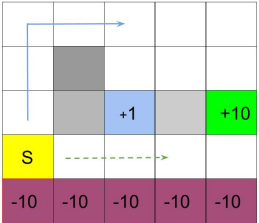

## Explanation - 

There are 4 possible optimal paths and it may change according to the values of the discount factor $\gamma$ and the noise factor $\eta$ in the environment. For that, let's analyze the characteristics of these paths and how they are influenced by $\gamma$ and  $\eta$.
#### Prefer the Close Exit (+1) but Risk the Cliff (Dashed Path to +1):
- Here, agent is willing to take the risky dashed path that leads to the close exit (+1).
- Low $\gamma$(close to 0) will encourage the agent to prioritize short-term rewards over long-ones, thus making the agent  choose the +1 reward over the +10 reward because it's closer.
- Low $\eta$ (close to 0) would mean that the agent's actions are mostly successful, hence it will risk the cliff and reach the cloaser goal faster(+1)

![Alt text](image-10.png)

#### Prefer the Far Exit (+10) but Risk the Cliff (Dashed Path to +10):
- Here, agent is willing to take the risky dashed path that leads to the distant exit (+1).
- High $\gamma$(close to 1) will encourage the agent to prioritize long-term rewards over short-ones, thus making the agent  choose the +10 reward over the +1 reward because even thought it's farther, the reward(+10) is much more than +1.
- Also, the number of extra steps taken is 2, and the discount factor being close to 1 would not discount the farther reward much.
- Low $\eta$ (close to 0) would mean that the agent's actions are mostly successful, hence it will risk the cliff and reach the cloaser goal faster(+1)
    
![Alt text](image-11.png)

#### Prefer the Close Exit (+1) and Avoid the Cliff (Solid Path to +1):
- Here, agent is willing to take the risky dashed path that leads to the close exit (+1).
- High $\gamma$(close to 1) will encourage the agent to prioritize long-term rewards over short-ones, thus making the agent  choose the +10 reward over the +1 reward because even thought it's farther, the reward(+10) is much more than +1.
- Also, the number of extra steps taken is 2, and the discount factor being close to 1 would not discount the farther reward much.
- High $\eta$ (close to 1) would mean that the agent's actions are mostly unsuccessful, hence it will prefer NOT to risk the cliff(which may yield a huge negative reward) at the cost of reaching the goal at more number of steps

![Alt text](image-8.png)
    
#### Prefer the Distant Exit (+10) and Avoid the Cliff (Solid Path to +10):
- Here, agent is willing to take the risky dashed path that leads to the close exit (+1).
- Low $\gamma$(close to 0) will encourage the agent to prioritize short-term rewards over long-ones, thus making the agent  choose the +1 reward over the +10 reward because it's closer.
- High $\eta$ (close to 1) would mean that the agent's actions are mostly unsuccessful, hence it will prefer NOT to risk the cliff(which may yield a huge negative reward) at the cost of reaching the goal at more number of steps

![Alt text](image-9.png)

## Q2(d)

![Alt text](image-6.png)
### Does scaling the discount factor by a constant κ ∈ (0, 1) alter the optimal policy ?

#### Ans :
Yes, scaling the discount factor by a constant κ ∈ (0, 1) alter the optimal policy. 
- As shown above depending upon the value of discount factor, the agent may prioritise long-term rewards ocer short-term and vice-versa.
- Low $\gamma$(close to 0) will encourage the agent to prioritize short-term rewards over long-ones, thus making the agent  choose the +1 reward over the +10 reward because it's closer.
- High $\gamma$(close to 1) will encourage the agent to prioritize long-term rewards over short-ones, thus making the agent  choose the +10 reward over the +1 reward because even thought it's farther, the reward(+10) is much more than +1.